# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
import seaborn as sns
plt.style.use('fivethirtyeight')

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [13]:
DATA_PATH = './donnees'

# Paramètres des géométries ascendante et descendante

In [3]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

# Chargement des données

In [14]:
import csv

def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

# numéro de la ligne ou commence les données
num_start = 44
# numéro de la ligne ou se trouve la liste des dates
num_list_dates = 40
# attributs présent dans les données
columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
# dictionnaire stockant les données
data = {column: [] for column in columns}
# liste des dates 
indexes = []
# series temporelles
series = []
# liste de dataframes
df_series = []

with open(DATA_PATH + '/' + 'MM_TIO_EW_31TGK_20151227_to_20200906.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    line_count = 1 
    for row in csv_reader:
        if line_count == num_list_dates:
            indexes = [row[0].split(' ')[1]] + row[1:]
        if line_count >= num_start:
            # extraction des premiers attributs
            for i in range(len(columns)):
                data[columns[i]].append(row[i])
            # extraction de l'attribut TS(série temporelle)
            series.append([float(v) for v in row[len(columns):]])
        line_count  += 1
    if len(indexes) != len(series[0]):
        print('Erreur : Les indexes et les valeurs ne correspondent pas')
    # convertir les index en date
    indexes = [d.strip()[0:8] for d in indexes]
    # créer une liste de dataframes, chacun contenant une série temporelle
    for serie in series:
        tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
        tmp_serie.sort_index(inplace=True)
        df_series.append(tmp_serie)
    # creer un dataframe pour les autres attributs
    df = pd.DataFrame(data)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df.set_index('id')

# Calcul de la vitesse instannée

In [32]:
def compute_velocity_time_series(series):
    n = len(series)
    m = len(series[0])
    for i in range(n):
        for j in range(m):
            try:
                duration = (series[i].index[j+1] - series[i].index[j-1]).days
                displacement = series[i].iloc[j+1]['displacement'] -  series[i].iloc[j-1]['displacement']
                series[i].loc[series[i].index[j], 'velocity'] = displacement / duration 
            except:
                continue

In [33]:
compute_velocity_time_series(df_series[:6])

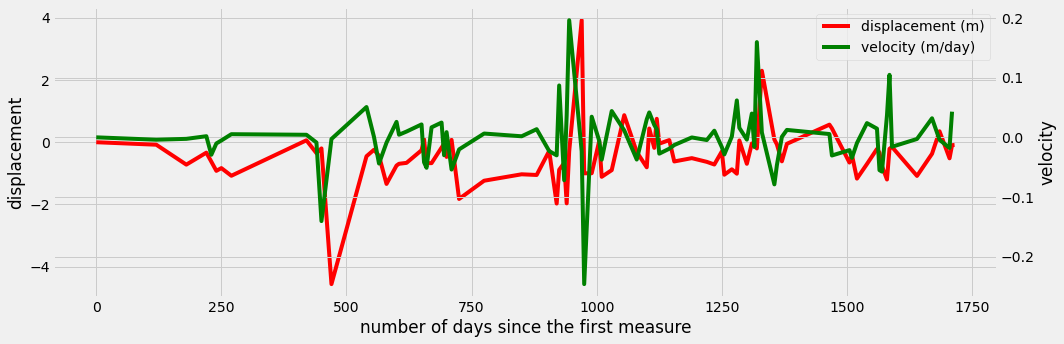

In [34]:
def get_days(dates):
    days = []
    for i in range(len(df_series[0])):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

days = get_days(df_series[0].index)

fig, ax_left = plt.subplots(figsize=(15,5))
ax_right = ax_left.twinx()

p1, = ax_left.plot(days, df_series[4]['displacement'], color='red', label='displacement (m)')
p2, = ax_right.plot(days, df_series[4]['velocity'], color='green', label='velocity (m/day)')

ax_left.set_xlabel("number of days since the first measure")
ax_left.set_ylabel("displacement")
ax_right.set_ylabel("velocity")

lns = [p1, p2]

ax_left.legend(handles=lns, loc='best')
fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


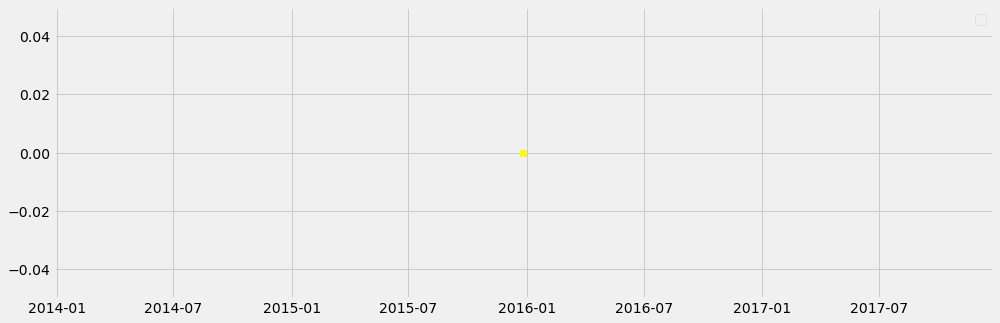

In [33]:
import matplotlib.pyplot as plt

Y = 2020
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]

x = df_series[0].index
y = df_series[0]['deplacement']

fig, ax = plt.subplots(figsize=(15,5))

season_colors = {season : color for (season, color) in zip(('winter', 'spring', 'summer', 'autumn'), ('green', 'purple', 'yellow', 'blue'))}
seasons_count = {season : 0 for season in ('winter', 'spring', 'summer', 'autumn')}
colors  = []
sample_seasons = []

for sample_date in df_series[0].index:
        sample_seasons.append(get_season(sample_date))
for season in sample_seasons:
    colors.append(season_colors[season])

for i in range(len(df_series[0])):
    ax.plot(df_series[0].iloc[0].name, df_series[0].iloc[0].deplacement, 'k', color=colors[i], marker='o')
    
ax.grid()
ax.margins(0)
    
plt.grid()
plt.legend()
plt.show()

In [31]:
from datetime import datetime
Y = 2000

def get_season(date):
    for season in seasons:
        name  = season[0]
        start = season[1].replace(year=date.year)
        end   = season[2].replace(year=date.year)
        if start <= date <= end:
            return name

In [32]:
def plot_season_serie(dates):
    
    seasons = []
    breakpoints_index = []
    intervalles = []
    
    for date in dates:
        seasons.append(get_season(date))
        
    start = 0
    i = 0
    ends = []
    while i < len(dates):
        while i < len(dates) and seasons[start] == seasons[i]:
            i += 1
        ends.append(i-1)
        start = i
        i += 1
        
    for end in ends:
        intervalles.append((seasons[end], dates[end]))
    
    return intervalles, ends, seasons

In [38]:
def count_samples_per_season(dates):
    samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
    for date in dates:
        samples_per_season[get_season(date)] += 1
    return samples_per_season

In [36]:
def plot_data_per_season(labels, values):

    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()

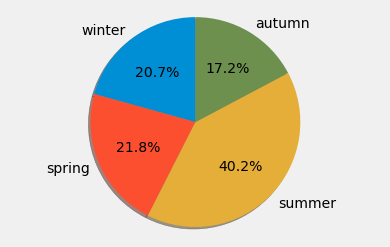

In [39]:
r = count_samples_per_season(df_series[0].index)
plot_data_per_season(list(r.keys()), list(r.values()))

In [40]:
indexes = df_series[0].index
durations = []
for i in range(len(indexes)-1):
    durations.append(abs((indexes[i+1] - indexes[i]).days))   

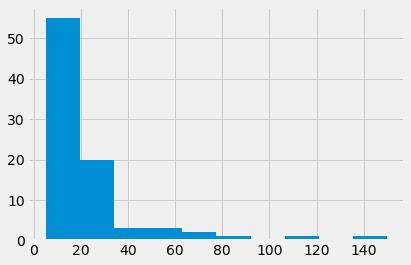

In [41]:
plt.hist(durations)
plt.show()

In [42]:
df['CosU'].describe()

count    87314.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: CosU, dtype: float64

In [ ]:
import simplekml
kml=simplekml.Kml()
style = simplekml.Style()
style.labelstyle.color = simplekml.Color.red  
style.labelstyle.scale = 2
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
for index, row in df.iterrows():
    kml.newpoint(name=row['Vel'], coords=[(row['Lat'], row['Lon'], row['Topo'])])
kml.save('ps.kml')  

In [43]:
num_rows = 6
num_cols = 4

def plot_series(series, num_rows=num_rows, num_cols=num_cols, colormap='tab20'):

    fig, axs = plt.subplots(num_rows,num_cols,figsize=(25,25))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

    for num_row in range(num_rows):
        for num_col in range(num_cols):
            if num_row*num_cols + num_col < len(series):
                axs[num_row, num_col].plot(series[num_row*num_cols + num_col],color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

    plt.show()


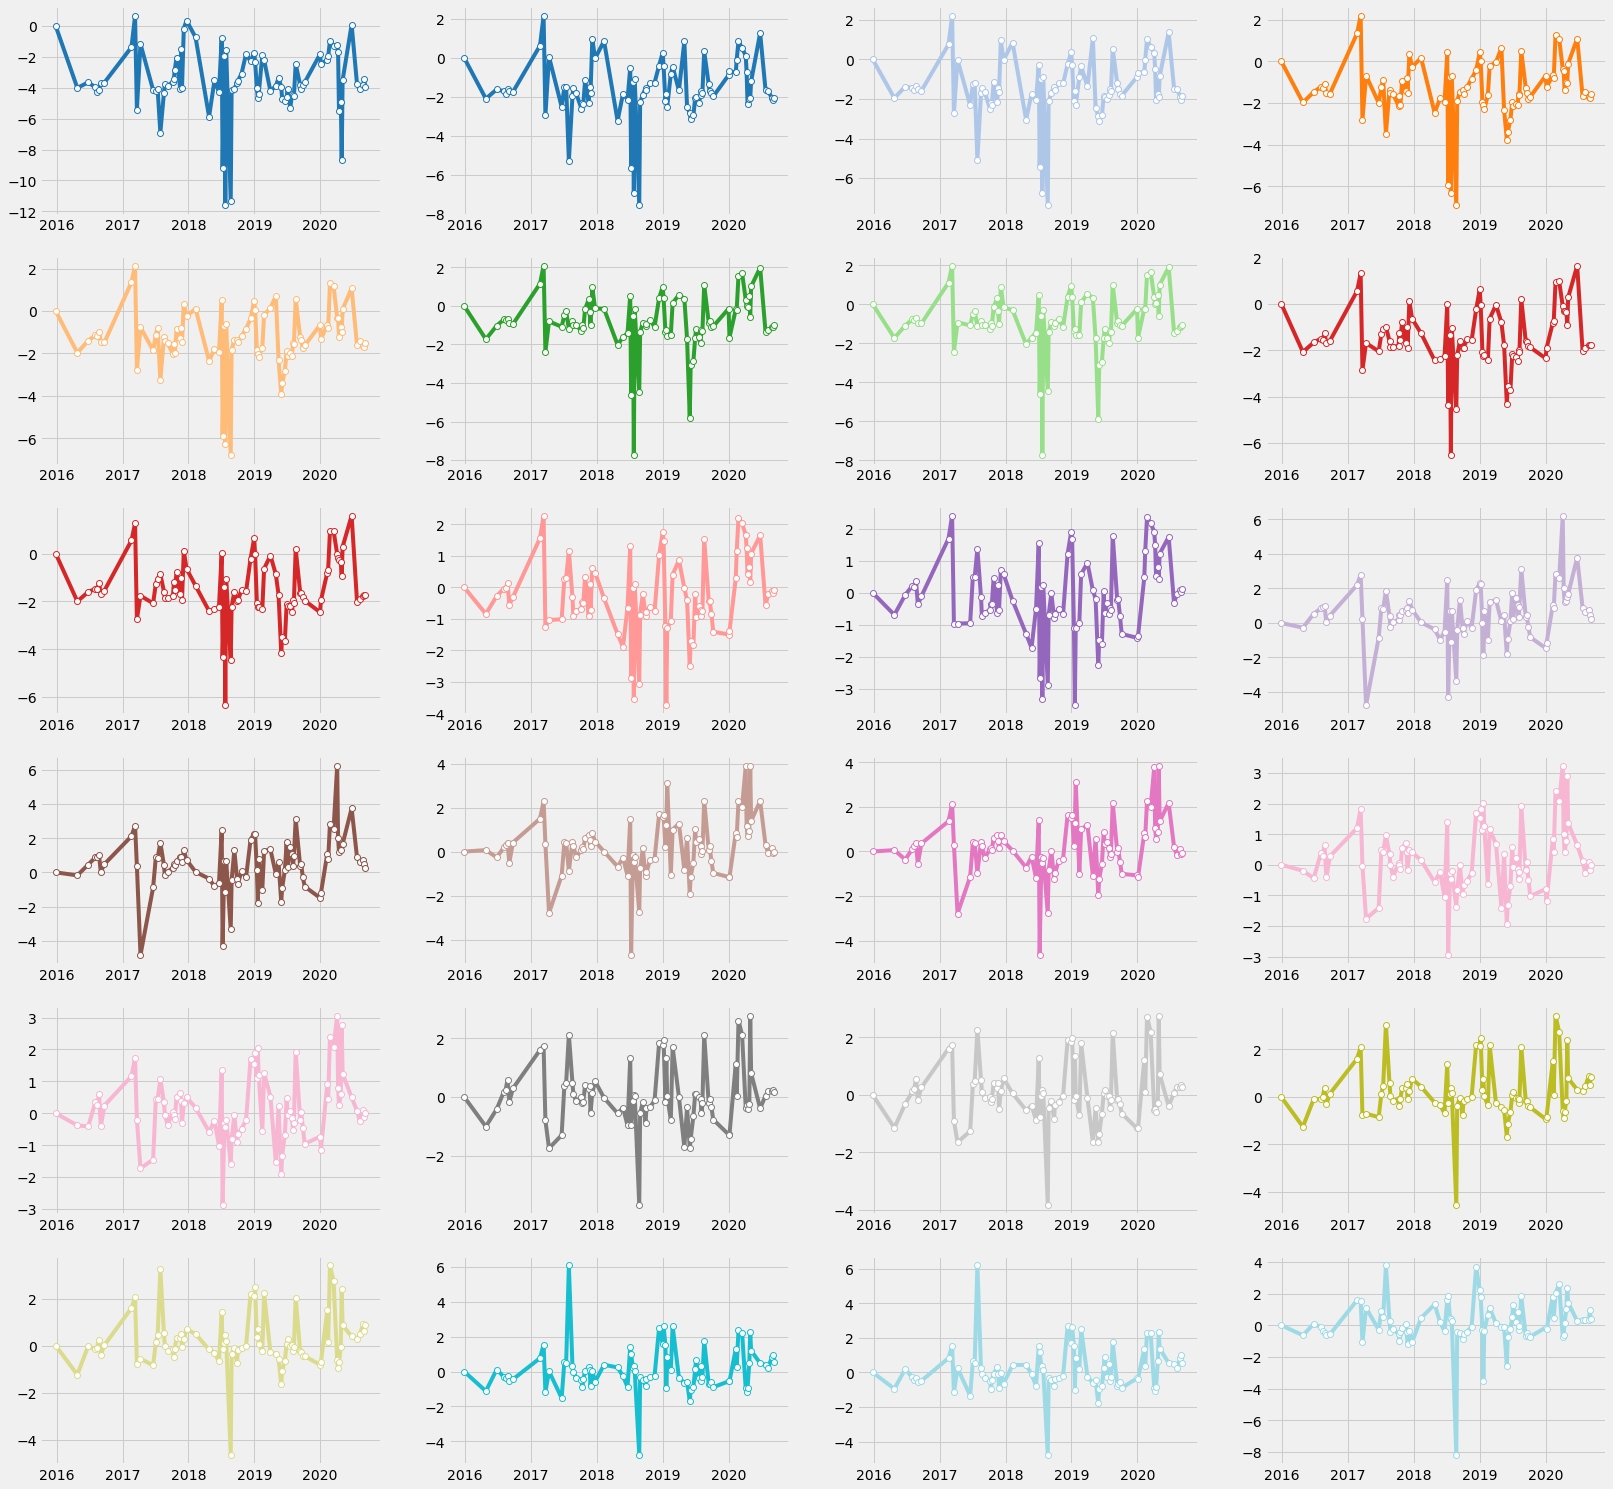

In [27]:
plot_series(df_series[4000:4040])

# Etude de la saisonnalité

# Réechantillonage des données

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

In [7]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def impute_time_series(serie):
    if serie.isnull().sum().sum() > 0:
        return serie.interpolate(limit_direction="both",inplace=False)
    else:
        return serie
    
def get_non_stationary(series, alpha=0.05, nb_nan_max=87):
    
    # nombre de series temporelles
    n_series = len(series)
    # liste contenant les indinces des séries temporelles non stationnaires
    non_stationary_series = []
    
    for i in range(len(series)):
        # imputer les series qui ont moins de nb_nan_max valeurs manquantes
        if series[i].isnull().sum().sum() < nb_nan_max: 
            serie = impute_time_series(series[i])
            result = adfuller(serie['displacement'])
            # le test de stationarité échoue automatiquement si la p-value est supérieure à 0.05
            if result[1] > alpha:
                non_stationary_series.append(i)
            
    return non_stationary_series

In [11]:
 non_stationary_index = get_non_stationary(df_series)

KeyboardInterrupt: 

In [137]:
non_stationary_series = []
for i in range(len(non_stationary_index)):
    non_stationary_series.append(df_series[non_stationary_index[i]])

In [ ]:
plot_series(non_stationary_series[0:50])

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [27]:
reg = LinearRegression()
reg.fit(df_series[0].index.values.reshape(-1,1), df_series[0]['displacement'].values.reshape(-1,1))

LinearRegression()

In [30]:
reg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}